# TuLiP Example: River Crossing

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from tulip import transys, spec, synth, dumpsmach
from fill_fts import *

# Binary vector to node name as string
def bv2str(bv):
  return ''.join('R' if b else 'L' for b in bv)

## Define finite transition system

In [ ]:
# State: [farmer fox chichen grain] \in {L,R}^4
fts = transys.FTS()

fts.sys_actions.add_from(['GoSelf', 'TakeFox', 'TakeChicken', 'TakeGrain'])

# Add nodes
for bv in product([0,1], repeat=4):
    fts.add_node(bv2str(bv))

# Initial state
fts.states.initial.add('LLLL')

# Add transitions
for i in range(2):
    for j in range(2):
        fts.add_edge(bv2str([0,0,i,j]), bv2str([1,1,i,j]), sys_actions='TakeFox')
        fts.add_edge(bv2str([0,i,0,j]), bv2str([1,i,1,j]), sys_actions='TakeChicken')
        fts.add_edge(bv2str([0,i,j,0]), bv2str([1,i,j,1]), sys_actions='TakeGrain')

        fts.add_edge(bv2str([1,1,i,j]), bv2str([0,0,i,j]), sys_actions='TakeFox')
        fts.add_edge(bv2str([1,i,1,j]), bv2str([0,i,0,j]), sys_actions='TakeChicken')
        fts.add_edge(bv2str([1,i,j,1]), bv2str([0,i,j,0]), sys_actions='TakeGrain')
        
        for k in range(2):
            fts.add_edge(bv2str([0,i,j,k]), bv2str([1,i,j,k]), sys_actions='GoSelf')
            fts.add_edge(bv2str([1,i,j,k]), bv2str([0,i,j,k]), sys_actions='GoSelf')
            
# Add trap state and fill in actions
fill_fts(fts)

# Plot transition system
fts.plot()

## Define atomic propositions and specification

In [ ]:
# Add atomic propositions
fts.atomic_propositions.add_from({'start', 'goal', 'danger'})

fts.node['LLLL']['ap'].add('start')
fts.node['RRRR']['ap'].add('goal')

for state in product([0,1], repeat=4):
  if state[1] == state[2] and state[1] != state[0]:
    # fox and chicken together, but no farmer
    fts.node[bv2str(state)]['ap'].add('danger')

  if state[2] == state[3] and state[2] != state[0]:
    # Chicken and grain together, but no farmer
    fts.node[bv2str(state)]['ap'].add('danger')

# Formula
env_vars = set()
env_init = set()
env_safe = set()
env_prog = set()
sys_vars = set()
sys_init = set()
sys_safe = {'! danger'}
sys_prog = {'goal'}
formula = spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                      env_safe, sys_safe, env_prog, sys_prog)

fts.plot()
print(formula.pretty())

## Solve synthesis problem

removed 0 nodes from 9 total


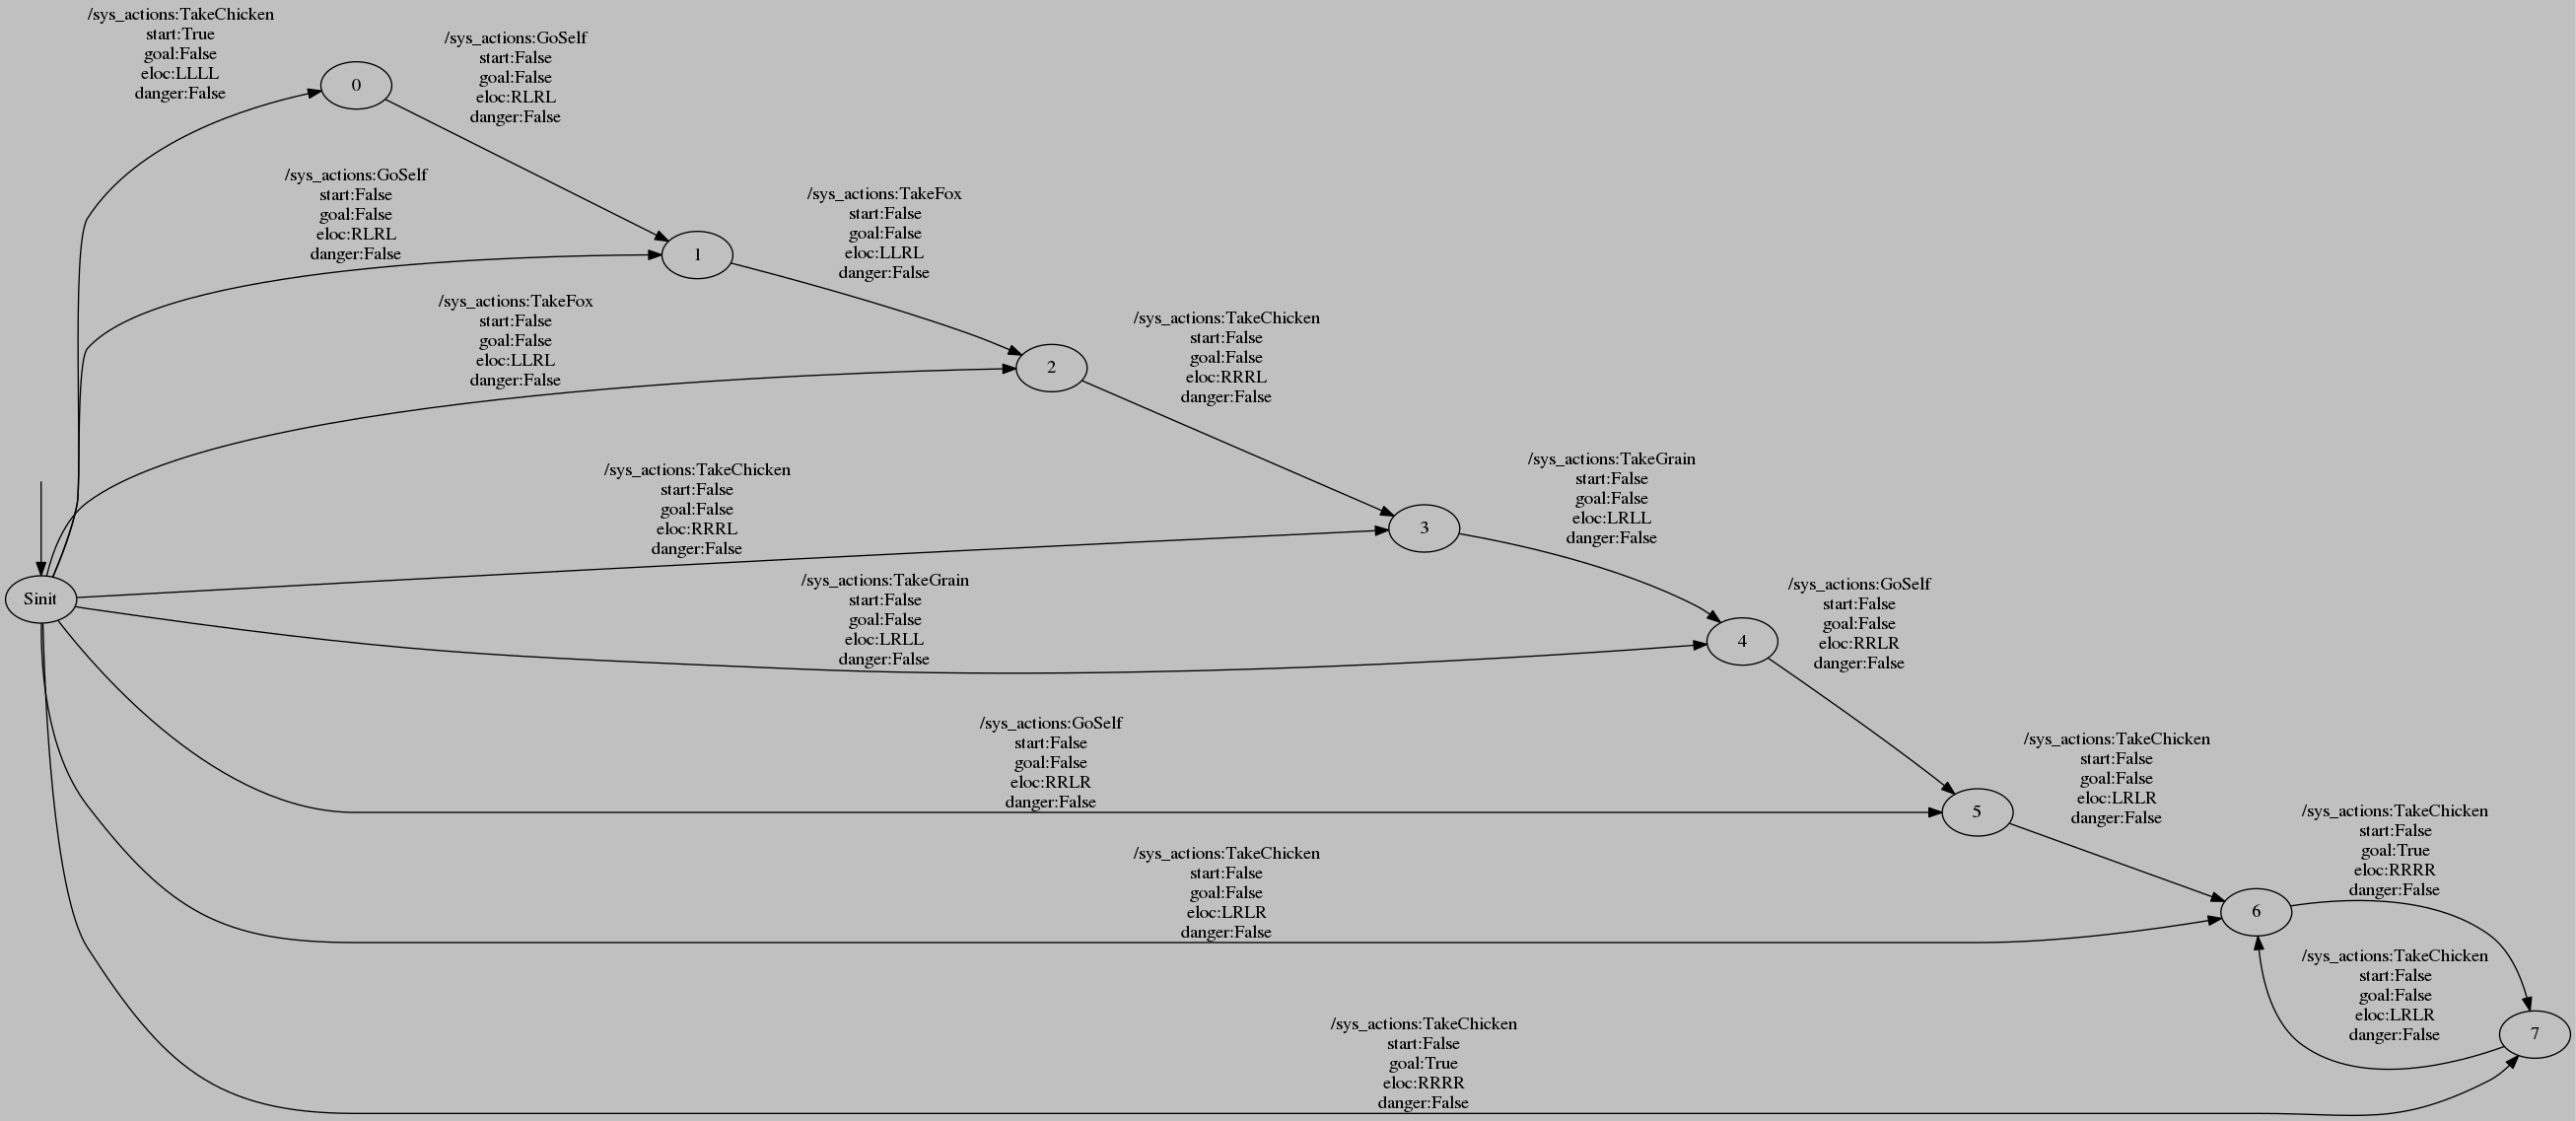

In [4]:
formula.moore = False
formula.plus_one = True
formula.qinit = '\A \E'
fts.owner = 'env'

ctrl = synth.synthesize('omega', formula, env=fts)

# Plot policy
ctrl.plot()

dumpsmach.write_python_case("river_policy.py", ctrl, classname="RiverPolicy")

## Simulation

In [5]:
from river_policy import RiverPolicy

loc = 'LLLL'

C = RiverPolicy()
for i in range(7):
    # APs at current loc
    start = 'start' in fts.node[loc]['ap']
    goal = 'goal' in fts.node[loc]['ap']
    danger = 'danger' in fts.node[loc]['ap']
    
    action = C.move(eloc=loc, start=start, goal=goal, danger=danger)['sys_actions']
    new_loc = [e[1] for e in fts.transitions.find(loc, with_attr_dict={'sys_actions':action})][0]
        
    print "moved from {} to {} using {}".format(loc, new_loc, action)
    
    loc = new_loc

moved from LLLL to RLRL using TakeChicken
moved from RLRL to LLRL using GoSelf
moved from LLRL to RRRL using TakeFox
moved from RRRL to LRLL using TakeChicken
moved from LRLL to RRLR using TakeGrain
moved from RRLR to LRLR using GoSelf
moved from LRLR to RRRR using TakeChicken


# Reactive synthesis

In [6]:
# If it rains we go back to left side
env_vars = {'rain'}
env_init = {'! rain'}
# introduce additional variable goBack to make spec GR(1)
# [] (rain -> <> start)  equivalent to [] ( (X (goBack) <-> start) || (goBack && !rain) ) && []<> goBack
sys_safe = {'(! danger) && (X (goBack) <-> start || (goBack && !rain))'}
sys_vars = {'goBack'}
sys_prog |= {'goBack'}

formula = spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                      env_safe, sys_safe, env_prog, sys_prog)

formula.moore = False
formula.plus_one = True
formula.qinit = '\A \E'
fts.owner = 'env'

print formula.pretty()

# Synthesize policy
ctrl = synth.synthesize('omega', formula, env=fts)

# Plot policy (large)
# ctrl.plot()

# Save policy
dumpsmach.write_python_case("river_policy_reactive.py", ctrl, classname="RiverPolicyReactive")

ENVIRONMENT VARIABLES:
	rain	boolean

SYSTEM VARIABLES:
	goBack	boolean

FORMULA:
ASSUMPTION:
    INITIAL
	  (! rain)
GUARANTEE:
    SAFETY
	  []((! danger) && (X (goBack) <-> start || (goBack && !rain)))
    LIVENESS
	  []<>(goBack)
	& []<>(goal)

removed 0 nodes from 53 total


## Simulation

In [7]:
from river_policy_reactive import RiverPolicyReactive

loc = 'LLLL'

C = RiverPolicyReactive()
for i in range(20):
    
    # APs at current loc
    start = 'start' in fts.node[loc]['ap']
    goal = 'goal' in fts.node[loc]['ap']
    danger = 'danger' in fts.node[loc]['ap']
        
    rain = i < 10
    if i == 10:
        print "it starts raining..."
        
    action = C.move(eloc=loc, start=start, goal=goal, danger=danger, rain=rain)['sys_actions']
    new_loc = [e[1] for e in fts.transitions.find(loc, with_attr_dict={'sys_actions':action})][0]
        
    print "moved from {} to {} using {}".format(loc, new_loc, action)
    
    loc = new_loc

moved from LLLL to RLRL using TakeChicken
moved from RLRL to LLRL using GoSelf
moved from LLRL to RRRL using TakeFox
moved from RRRL to LRLL using TakeChicken
moved from LRLL to RRLR using TakeGrain
moved from RRLR to LRLR using GoSelf
moved from LRLR to RRRR using TakeChicken
moved from RRRR to LRLR using TakeChicken
moved from LRLR to RRRR using TakeChicken
moved from RRRR to LRLR using TakeChicken
it starts raining...
moved from LRLR to RRLR using GoSelf
moved from RRLR to LLLR using TakeFox
moved from LLLR to RLRR using TakeChicken
moved from RLRR to LLRL using TakeGrain
moved from LLRL to RLRL using GoSelf
moved from RLRL to LLLL using TakeChicken
moved from LLLL to RLRL using TakeChicken
moved from RLRL to LLLL using TakeChicken
moved from LLLL to RLRL using TakeChicken
moved from RLRL to LLRL using GoSelf
